In [12]:
from __future__ import division

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_style('whitegrid')
sns.set_palette('colorblind')

np.random.seed(40997)

In [13]:
import datagenerators as dg


In [31]:
observed_data_0 = dg.generate_dataset_0()
observed_data_0.tail()
len(observed_data_0[observed_data_0.x == 0]), len(observed_data_0[observed_data_0.x == 1])
# X = wearing hat, Y = productivity

(252, 248)

### Estimate Conditional

In [15]:
%%latex
\begin{align}
\mathbb{E}[Y=1|X=1] - \mathbb{E}[Y=1|X=0] 
\end{align}

<IPython.core.display.Latex object>

In [180]:
def estimate_uplift(ds):
    c, t = ds[ds.x == 0], ds[ds.x==1]
    delta = t.y.mean() - c.y.mean()
    # 95% confidence interval for standard normal is [-1.96, 1.96]
    err = 1.96*np.sqrt( (t.y.var() / t.shape[0] + c.y.var() /c.shape[0]) )
    return {'estimated_effect': delta, 'standard_err': err}

In [148]:
estimate_uplift(observed_data_0)

{'estimated_effect': -0.10816692268305167,
 'standard_err': 0.087296361223711094}

### Chi2 test for categorical data

In [149]:
from scipy.stats import chi2_contingency
contingency_table = (
    observed_data_0
    .assign(placeholder=1)
    .pivot_table(index='x', columns='y', values='placeholder', aggfunc='sum')
    .values
)
contingency_table

_, p, _, _ = chi2_contingency(contingency_table, lambda_='log-likelihood')
p
# p > .05, say and so Null hypothesis holds. ????
# There is a significant relationship between wearing hat (X) and productivity (Y) ???

0.019712554881038489

In [150]:
def run_ab_test(datagenerator, nsamples=10000, filter_=None):
    '''
    Generate nsamples using datagenerator with 50% X=1 and the other X=0.
    Run the results through uplift to get the estimated conditional effect
    (avg treatment effect)
    '''
    nsamples_a = int(nsamples/2)
    nsamples_b = nsamples - nsamples_a
    setX = np.concatenate([np.ones(nsamples_a), np.zeros(nsamples_b)]).astype(np.int64)
    ds = datagenerator(nsamples, set_X=setX)
    if (filter_ != None):
        ds = ds[filter_(ds)].copy()
    return estimate_uplift(ds)

run_ab_test(dg.generate_dataset_0)
# low p-value < .05 indicates null hypothesis needs to be rejected - that is there is no relationship between
# wearing a hat and productivity. Why this reversal? Because in our A/B test we randomized the X's, and it teases
# out the relation between X, Y

{'estimated_effect': 0.19500000000000006, 'standard_err': 0.019224274761603016}

## Causality
Average Treatment Effect: $ \Delta = E[Y_1] - E[Y_0] $, where $Y_1$ is the outcome when the entire population is treated, and $Y_0$ is the outcome when no one is treated (control). In RCT, $Y_1, Y_0 \perp X$. However, in Observational studies, we assume $ Y_1, Y_0 \perp X \text{ } | \text{ }Z$, where $Z$ are the control variates. Therefore, $P(X, Y_0, Y_1, Z) = P(Z)P(X|Z)P(Y_0,Y_1|Z)$

In [45]:
observed_with_confounders = dg.generate_dataset_0(show_z=True)
print(estimate_uplift(observed_with_confounders.loc[lambda df: df.z==0]))
print(estimate_uplift(observed_with_confounders.loc[lambda df: df.z==1]))
#
# We see positive effects of hat and productivity in both splits, with Z=1 (skilled) and Z=0 (unskilled)
#

{'estimated_effect': 0.25333333333333335, 'standard_err': 0.052167040467244345}
{'estimated_effect': 0.12639553429027117, 'standard_err': 0.072451436661551447}


### Approach 1: Modeling Counter factual
Use estimators of $Y_0, Y_1$

$\hat{Y_0}(Z) = E[Y|Z, X=0] $

$\hat{Y_1}(Z) = E[Y|Z, X=1] $

ATE = $\Delta = \frac{1}{N} \sum_i(\hat{Y_1}(z_i) - \hat{Y_0}(z_i))$


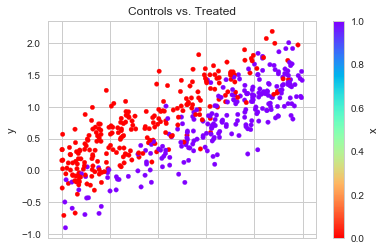

In [75]:
observed_1 = dg.generate_dataset_1()
observed_1.plot.scatter(x='z', y='y', c='x', cmap='rainbow_r', colorbar=True)
plt.title('Controls (RED) vs. Treated')
# set title color
# tobj = plt.title('Controls vs. Treated')
# plt.setp(tobj, color='r') 

In [67]:
observed_1.head() #, observed_1.tail()

,x,y,z
0,1,0.958249,0.717579
1,1,0.669238,0.483711
2,1,1.375049,0.943936
3,0,1.218325,0.503694
4,1,1.210632,0.993055


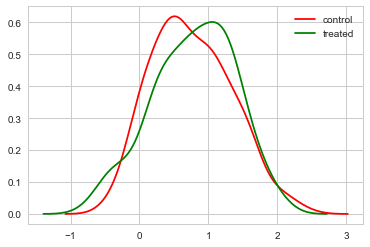

In [52]:
sns.kdeplot(observed_1.loc[lambda df: df.x == 0].y, color='r', label='control')
sns.kdeplot(observed_1.loc[lambda df: df.x == 1].y, color='g', label='treated')


In [64]:
print("Observed ATE: {estimated_effect:.3f}, ({standard_err:.3f})".format(**estimate_uplift(observed_1)))


Observed ATE: 0.085, (0.037)


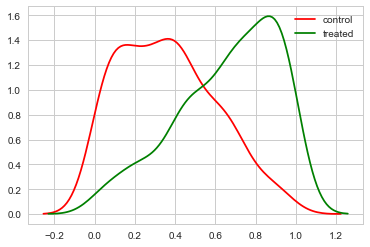

In [69]:
sns.kdeplot(observed_1[lambda df: df.x == 0].z, color='r', label='control')
sns.kdeplot(observed_1[lambda df: df.x == 1].z, color='g', label='treated')

In [70]:
# Real ATE by running A/B test
print('Real ATE: {estimated_effect:.3f}, ({standard_err:.3f})'.format(**run_ab_test(dg.generate_dataset_1)))

Real ATE: -0.520, (0.009)


#### Linear Model for the counterfactual
$Y_0 = \alpha + \beta Z + \epsilon $

$Y_1 = Y_0 + \gamma $

pip install causalinference

In [78]:
from causalinference import CausalModel
cm = CausalModel(
    Y=observed_1.y.values, # y, outcome
    D=observed_1.x.values, # x, treatment
    X=observed_1.z.values  # z confounders
)
cm.est_via_ols(adj=1)
print(cm.estimates)
#
# The package does really well because the input data is linear and designed to
# meet the expectations
#


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.510      0.030    -16.917      0.000     -0.569     -0.451



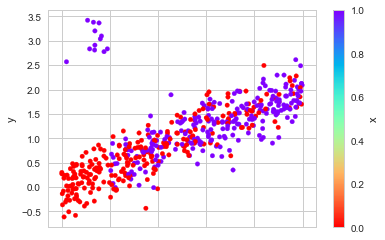

In [79]:
#
# Check against a data that is not designed to such assumptions
#
observed_2 = dg.generate_dataset_2()
observed_2.plot.scatter(x='z',y='y',c='x', cmap='rainbow_r', colorbar=True)

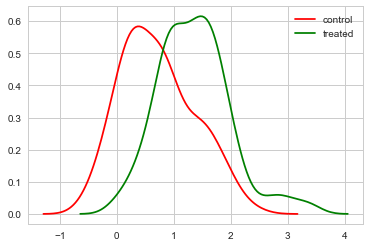

In [82]:
sns.kdeplot(observed_2[lambda df: df.x==0].y, color='r', label='control')
sns.kdeplot(observed_2[lambda df: df.x==1].y, color='g', label='treated')


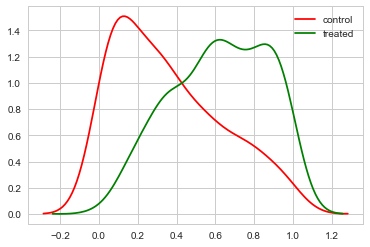

In [83]:
sns.kdeplot(observed_2[lambda df: df.x==0].z, color='r', label='control')
sns.kdeplot(observed_2[lambda df: df.x==1].z, color='g', label='treated')


In [86]:
#
# Here the effects are not additive
#
print('Observed ATE: {estimated_effect:.3f} ({standard_err:.3f})'.format(**estimate_uplift(observed_2)))
print('Real ATE: {estimated_effect:.3f} ({standard_err:.3f})'.format(**run_ab_test(dg.generate_dataset_2)))

Observed ATE: 0.641 (0.040)
Real ATE: 0.569 (0.011)


In [87]:
cm = CausalModel(
    Y=observed_2.y.values,
    D=observed_2.x.values,
    X=observed_2.z.values
)
cm.est_via_ols(adj=1)
print(cm.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.244      0.074      3.292      0.001      0.099      0.390



In [92]:
#
# Estimates by matching
#
cm = CausalModel(
    Y=observed_2.y.values,
    D=observed_2.x.values,
    X=observed_2.z.values
)

cm.est_via_matching()
print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.535      0.139      3.863      0.000      0.264      0.807
           ATC      0.979      0.170      5.759      0.000      0.646      1.312
           ATT      0.074      0.168      0.439      0.661     -0.256      0.404



### Approach 2: Covariate Imbalance (matching?)

Observed ATE: 1.323, (0.029)
Real ATE: 2.456, (0.012)


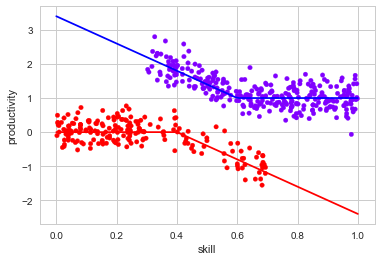

In [112]:
#
# Imbalanced control vs treatment
#
observed_3 = dg.generate_dataset_3()
observed_3.plot.scatter(x='z',y='y',c='x', cmap='rainbow_r', colorbar=False)
#plt.xticks(np.arange(observed_3.z.min(),observed_3.z.max(), .1))
plt.xlabel('skill')
plt.ylabel('productivity')
# plt.show()

#print(observed_3.z.min(),observed_3.z.max())
# actual response curves (data generators)
z = np.linspace(0,1,100)
y0 = np.where(z>=0.4, -4*(z-0.4), 0)
y1 = np.where(z<0.6, -4*(z-0.6), 0) + 1.

plt.plot(z, y0, color='r' )
plt.plot(z, y1, color='b' )

print("Observed ATE: {estimated_effect:.3f}, ({standard_err:.3f})".format(**estimate_uplift(observed_3)))
print("Real ATE: {estimated_effect:.3f}, ({standard_err:.3f})".format(**run_ab_test(dg.generate_dataset_3)))

In [115]:
# OLS estimator
cm = CausalModel(
    Y=observed_3.y.values,
    D=observed_3.x.values,
    X=observed_3.z.values
)
cm.est_via_ols()
print(cm.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      1.933      0.052     37.451      0.000      1.832      2.034
           ATC      1.940      0.055     35.303      0.000      1.832      2.047
           ATT      1.929      0.066     29.189      0.000      1.799      2.058



In [114]:
# Matching
cm = CausalModel(
    Y=observed_3.y.values,
    D=observed_3.x.values,
    X=observed_3.z.values
)
cm.est_via_matching()
print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      1.877      0.163     11.521      0.000      1.557      2.196
           ATC      1.830      0.277      6.597      0.000      1.286      2.374
           ATT      1.906      0.196      9.734      0.000      1.522      2.290



In [118]:
print(cm.summary_stats)


Summary Statistics

                       Controls (N_c=194)         Treated (N_t=306)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y       -0.109        0.450        1.214        0.453        1.323

                       Controls (N_c=194)         Treated (N_t=306)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        0.268        0.203        0.686        0.199        2.078



### Approach 3: Inverse Propensity Score Weighting
How likely is it for a subject to have received treatment?

$\hat{p}(Z) = P[X|Z] $

Probability of potential outcome, $Y_i$:
$P(Y_i) = P(Y_i|X=i) P(X=i)$

So, we can estimate $E[Y_i] $ (inverse propensity score weight estimator, IPS), 

$ = \Delta_{IPS} = \frac{1}{N}\big{(}\sum_{x_i = 1}\frac{y_i}{\hat{p}(z_i)} - \sum_{x_i = 0}\frac{y_i}{1. - \hat{p}(z_i)}\big{)}$

In [142]:
cm = CausalModel(
    Y=observed_1.y.values,
    D=observed_1.x.values,
    X=observed_1.z.values
)
cm.est_propensity_s()
propensity = cm.propensity['fitted']
#print(propensity)

df = observed_1

def compute_ipse(df, propensity):
    df['ips'] = np.where(df.x == 1, 1./propensity, 1./(1.-propensity))
    df['ipsw'] = df.y * df.ips

    ipse = (df[df.x==1].ipsw.sum() - df[df.x==0].ipsw.sum())/(1. * df.shape[0])
    return ipse
    # print(ipse)
#
# Compare this to the real ATE for observed_1 from previously (way above)
# Real ATE: -0.520, (0.009)
#
print(compute_ipse(df, propensity))

-0.486394457147


In [145]:
#
# If we used logistic regression to estimate the propensity score, the outcome is slightly poorer
#
def compute_propensity_lg(df):
    from sklearn.linear_model import LogisticRegression
    lg = LogisticRegression()
    X = df.z.values[:, np.newaxis]
    #print(X)
    #X = df.z.values.reshape(-1,1)
    y = df.x.values
    lg.fit(X,y)
    return lg.predict_proba(X)[:,1] # probability of predicting class '1'

df = dg.generate_dataset_1()
print(compute_ipse(df, compute_propensity_lg(df)))
# The propensity computed by logistic regression is lower? (because it is not inversely weighted?)


-0.435559813357


### Approach 4: Doubly Robust Weighted Estimator
This technique combines the inverse propensity score weighted and the linear estimators

In [146]:
observed_1 = dg.generate_dataset_1()
cm = CausalModel(
    Y=observed_1.y.values,
    D=observed_1.x.values,
    X=observed_1.z.values
)
cm.est_propensity_s()
cm.est_via_weighting()
print(cm.estimates)


Treatment Effect Estimates: Weighting

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.453      0.038    -12.013      0.000     -0.527     -0.379



### Unconfoundedness and Propensity Score
A stronger assumption than $Y_1, Y_0 \perp X \text{ }| \text{ } Z$ is

$ Y_1, Y_0 \perp X \text{ } | \text{ } \hat{p}(Z)$, that is given propensity

### Approach 5: Trimming (Calipers?)
Imbalances in covariates can cause issues. A solution is to make predictions for counterfactuals in regions where there is a good overlap, and "trim" points where there is not any overlap. For high dimensional data it is difficult to define good overlap. Trimming based on propensity scores is one approach


In [152]:
# Look at dataset 3, where there is poor overlap
cm = CausalModel(
    Y=observed_3.y.values,
    D=observed_3.x.values,
    X=observed_3.z.values
)

cm.est_propensity_s()
cm.trim_s()
cm.est_via_matching()
print(cm.estimates)
#
# Real ATE: 2.456, (0.012)
#


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      1.824      0.113     16.199      0.000      1.604      2.045
           ATC      1.848      0.218      8.473      0.000      1.420      2.275
           ATT      1.807      0.094     19.183      0.000      1.623      1.992



Observed ATE[mask]: 1.625, (0.117)
Real ATE[mask]: 2.005, (0.031)


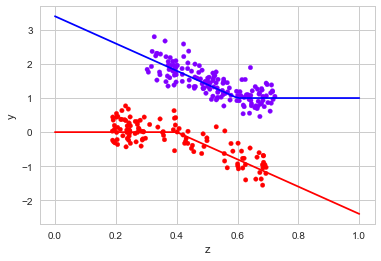

In [173]:
# Visualize the trimmed data
propensity = cm.propensity['fitted']
#print(cm.cutoff)
#print(propensity[:20])
mask = (propensity > cm.cutoff) & ( propensity < 1. - cm.cutoff)
#print(mask[:20])
def plot_actuals(plt):
    z = np.linspace(0,1,100)
    y0 = np.where(z >=0.4, -4*(z-.4), 0 )
    y1 = np.where(z < 0.6, -4*(z-.6), 0) + 1
    plt.plot(z,y0,'r')
    plt.plot(z,y1,'b')

plt = observed_3[mask].plot.scatter(x='z',y='y',c='x', cmap='rainbow_r', colorbar=False)
plot_actuals(plt)

filter_ = lambda df: (df.z > 0.2) & (df.z < 0.7)
print("Observed ATE[mask]: {estimated_effect:.3f}, ({standard_err:.3f})".format(**estimate_uplift(observed_3[mask])))
print("Real ATE[mask]: {estimated_effect:.3f}, ({standard_err:.3f})".format(**run_ab_test(dg.generate_dataset_3, 
                                                                                          filter_=filter_)))


### Approach 6: Stratification (or blocking estimator)
Another use of the propensity score is in the stratified or blocking estimator. It consists of grouping data points into groups of similar propensity and to estimate the ATE within these groups. 

In [174]:
# Use stratify to specify the boundaries or stratify_s to have it picked automatically

observed_1 = dg.generate_dataset_1()
cm = CausalModel(
    Y=observed_1.y.values,
    D=observed_1.x.values,
    X=observed_1.z.values
)

cm.est_propensity_s()
cm.stratify_s()
print(cm.strata)


Stratification Summary

              Propensity Score         Sample Size     Ave. Propensity   Outcome
   Stratum      Min.      Max.  Controls   Treated  Controls   Treated  Raw-diff
--------------------------------------------------------------------------------
         1     0.108     0.162        58         6     0.133     0.127    -0.428
         2     0.162     0.209        25         6     0.185     0.194    -0.463
         3     0.209     0.269        19        12     0.227     0.234    -0.467
         4     0.269     0.508        82        43     0.374     0.385    -0.507
         5     0.512     0.782        41        84     0.655     0.669    -0.453
         6     0.784     0.909        18       106     0.838     0.852    -0.332



In [176]:
# Compute overall ATE
cm.est_via_blocking()
print(cm.estimates)


Treatment Effect Estimates: Blocking

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.458      0.029    -15.966      0.000     -0.514     -0.401
           ATC     -0.473      0.033    -14.338      0.000     -0.537     -0.408
           ATT     -0.443      0.033    -13.478      0.000     -0.508     -0.379



-0.0372155727397 0.979527814602
(-0.037215572739658656, 0.061446934599482098, -0.098662507339140754, 0.024231361859823441)


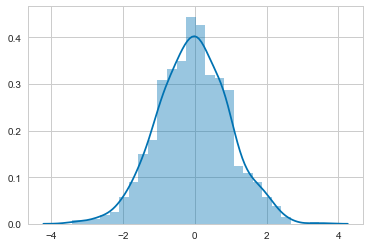

In [201]:
# Just an aside
# Compute a confidence interval from sample
# https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
#
import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h, m-h, m+h

a = np.random.randn(1000,)
sns.distplot(a)
# import matplotlib.pyplot as plt
# plt.scatter(a, range(len(a)))
# plt.show()
# print(a[:10])
#print(scipy.stats.norm.stats(a, 'mvsk'))
print(np.mean(a), np.var(a))
print(mean_confidence_interval(a,.95))

### Various Methods
Let's try all these

In [208]:
data_gen = dg.generate_exercise_dataset_2
ds = data_gen()

print("Observed ATE: {estimated_effect:.3f} ({standard_err:.3f})".format(**estimate_uplift(ds)))
print("Real ATE: {estimated_effect:.3f} ({standard_err:.3f})".format(**run_ab_test(data_gen)))

zs = [c for c in ds.columns if c.startswith("z")]
cm = CausalModel(
    Y=ds.y.values,
    D=ds.x.values,
    X=ds[zs].values # confounders
)
print(zs)

cm.est_via_ols()
cm.est_via_matching()

#ipsw
cm.est_propensity_s()
cm.est_via_weighting()

#stratified
cm.stratify_s()
cm.est_via_blocking()

print(cm.estimates)

Observed ATE: 0.118 (0.665)
Real ATE: 4.504 (0.186)
['z_0', 'z_1', 'z_2', 'z_3', 'z_4']

Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.474      0.321      1.476      0.140     -0.155      1.104
           ATC      0.750      0.332      2.260      0.024      0.100      1.401
           ATT      0.346      0.335      1.030      0.303     -0.312      1.003

Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      1.768      0.498      3.552      0.000      0.792      2.743
           ATC      1.598      0.625      2.556      0.011      0.373      2.824
           ATT      1.846      0.548      3.367      0.001      0.771      2.922

Treatment Effect Estimates: 

In [209]:
cm.estimates

{'ols': {'ate': 0.47419777090420356, 'ate_se': 0.32116657752282168, 'atc': 0.75020996241911453, 'att': 0.34550000418610732, 'atc_se': 0.33195237063060334, 'att_se': 0.33546747808044225}, 'matching': {'atc': 1.5983416141984819, 'att': 1.8464926008999762, 'ate': 1.7675805871289012, 'atc_se': 0.62526736068696021, 'att_se': 0.54847357409903819, 'ate_se': 0.49758450947551408}, 'weighting': {'ate': 3.6538297598650313, 'ate_se': 0.95614235242183243}, 'blocking': {'ate': 1.2013569062060201, 'atc': -0.053889561123241191, 'att': 1.7866477810017753, 'ate_se': 0.33320254112880332, 'atc_se': 0.46840424000538011, 'att_se': 0.35128984048406586}}

(-0.5, 3.5)

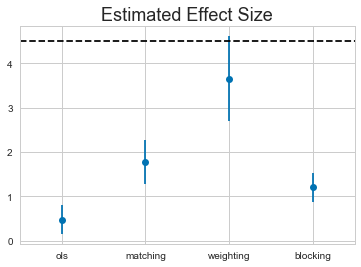

In [210]:
y = []
yerr = []
x_label = []

for method, result in dict(cm.estimates).items():
    y.append(result['ate'])
    yerr.append(result['ate_se'])
    x_label.append(method)

x = np.arange(len(y))

plt.errorbar(x=x, y=y, yerr=yerr, linestyle='none', capsize=5, marker='o')
plt.xticks(x, x_label)
plt.title('Estimated Effect Size', fontsize=18)
plt.hlines(4.5, -.5, 3.5, linestyles='dashed')
plt.xlim(-.5,3.5)